In [1]:
import numpy
import pandas

import conntility

from scipy.spatial.distance import cdist
import tqdm

from matplotlib import pyplot as plt

In [36]:
fn_data = "/gpfs/bbp.cscs.ch/project/proj159/home/reimann/connectivity_higher_order_effect_24-11-11.h5"


# NOTE:
# For this analysis "pre" means that we are measuring the effect a connected nearest neighbor on the pre-synaptic
# side has. Hence, it is an effect of INCOMING connectivity.
df_pre = pandas.read_hdf(fn_data, key="microns/pre")
df_post = pandas.read_hdf(fn_data, key="microns/post")

In [37]:
def corrcoef_from_contingency(series_in, cols_touches, col_values):
    x = series_in[cols_touches[0]].values
    y = series_in[cols_touches[1]].values
    z = series_in[col_values].values
    mn1 = (x * z).sum() / z.sum()
    mn2 = (y * z).sum() / z.sum()
    cov = ((x - mn1) * (y - mn2) * z).sum() / z.sum()

    v1 = (((x - mn1) ** 2) * z).sum() / z.sum()
    v2 = (((y - mn2) ** 2) * z).sum() / z.sum()

    return cov / numpy.sqrt(v1 * v2)

cc_pre = df_pre.groupby(["xz", "y"]).apply(corrcoef_from_contingency, ["touches_pair", "touches_nn_pre"], "count")
cc_post = df_post.groupby(["xz", "y"]).apply(corrcoef_from_contingency, ["touches_pair", "touches_nn_post"], "count")


Text(0.5, 1.0, 'Microns: outgoing nn')

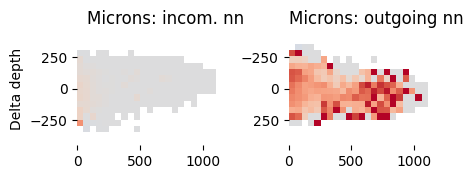

In [58]:
clim = [-0.15, 0.15]
cmap = "coolwarm"

def make_extent(df):
    delta_xz = df.columns[-1] - df.columns[-2]
    delta_y = df.index[-1] - df.index[-2]
    
    extent = [df.columns[0] - delta_xz/2, df.columns[-1] + delta_xz/2,
             df.index[-1] + delta_y/2, df.index[0] - delta_y/2]
    return extent

fig = plt.figure(figsize=(5, 3))

ax = fig.add_subplot(1, 2, 1)
img = cc_pre.sort_index().unstack("xz")
ax.imshow(img, extent=make_extent(img), clim=clim, cmap=cmap)
ax.set_ylim(sorted(ax.get_ylim()))
ax.set_frame_on(False)
ax.set_title("Microns: incom.")
ax.set_ylabel("Delta depth")

ax = fig.add_subplot(1, 2, 2)
img = cc_post.sort_index().unstack("xz")
ax.imshow(img, extent=make_extent(img), clim=clim, cmap=cmap)
ax.set_frame_on(False)
ax.set_title("Microns: outgoing")


# NOTE:
# For the y-axis, in BOTH cases a negative number indicates an upwards connections.
# The orientation of the y-axis is intentionally different in both plots to correctly display that!

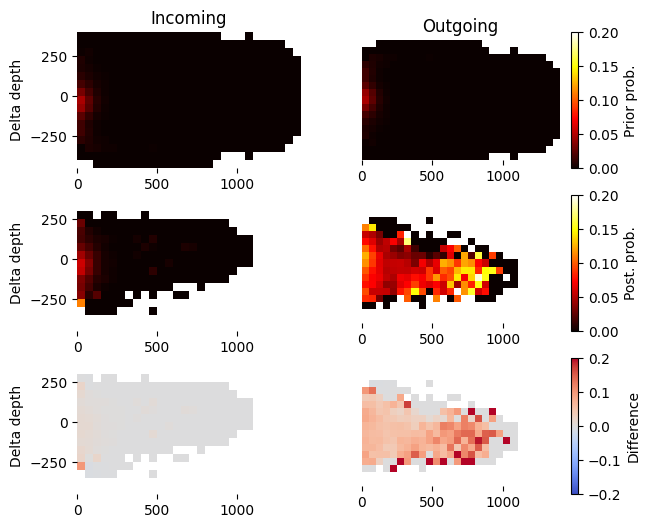

In [61]:
def p_prior_post_fun(df_in, thresh=1, col="touches_nn_post"):
    v = df_in["touches_pair"] >= thresh
    prior = df_in.loc[v]["count"].sum() / df_in["count"].sum()
    df_in = df_in.loc[v]
    v = df_in[col] >= thresh
    posterior = df_in.loc[v]["count"].sum() / df_in["count"].sum()
    return pandas.Series({
        "prior": prior,
        "posterior": posterior
    })


clim = [0.0, 0.2]
cmap = "hot"
thresh = 1

fig = plt.figure(figsize=(7, 6))
dfs = [df_pre, df_post]
cols = ["touches_nn_pre", "touches_nn_post"]
titles = ["Incoming", "Outgoing"]

for i in range(len(dfs)):
    dsrc = dfs[i]
    extent = make_extent(dsrc.groupby(["xz", "y"])["count"].sum().unstack("xz").iloc[:-1])
    ylim = [extent[-1], extent[-2]]
    if numpy.mod(i, 2) == 1:
        ylim = [extent[-2], extent[-1]]
    res = dsrc.groupby(["xz", "y"]).apply(p_prior_post_fun, thresh=thresh, col=cols[i])
    
    ax = fig.add_subplot(3, len(dfs), i + 1)
    img = res["prior"].sort_index().unstack("xz")
    pltimg = ax.imshow(img, extent=make_extent(img), clim=clim, cmap=cmap)
    ax.set_ylim(ylim)
    ax.set_frame_on(False)
    #ax.set_title("Thresh: {0}".format(thresh))
    if i == 0:
        ax.set_ylabel("Delta depth")
    else:
        ax.set_yticks([])
    ax.set_title(titles[i])
    if i == (len(dfs) - 1):
        plt.colorbar(pltimg, label="Prior prob.")
    # ax.set_yticklabels(numpy.abs(ax.get_yticks()).astype(int))
    
    ax = fig.add_subplot(3, len(dfs), i + len(dfs) + 1)
    img = res["posterior"].sort_index().unstack("xz")
    pltimg = ax.imshow(img, extent=make_extent(img), clim=clim, cmap=cmap)
    ax.set_ylim(ylim)
    ax.set_frame_on(False)
    if i == 0:
        ax.set_ylabel("Delta depth")
    else:
        ax.set_yticks([])
    if i == (len(dfs) - 1):
        plt.colorbar(pltimg, label="Post. prob.")
    # ax.set_yticklabels(numpy.abs(ax.get_yticks()).astype(int))
        
    ax = fig.add_subplot(3, len(dfs), i + len(dfs) + len(dfs) + 1)
    img = (res["posterior"] - res["prior"]) # / (res["prior"] + res["posterior"])
    img = img.sort_index().unstack("xz")
    pltimg = ax.imshow(img, extent=make_extent(img), clim=[-clim[1], clim[1]], cmap="coolwarm")
    ax.set_ylim(ylim)
    ax.set_frame_on(False)
    if i == 0:
        ax.set_ylabel("Delta depth")
    else:
        ax.set_yticks([])
    if i == (len(dfs) - 1):
        plt.colorbar(pltimg, label="Difference")
    # ax.set_yticklabels(numpy.abs(ax.get_yticks()).astype(int))


In [72]:
fn_data = "/gpfs/bbp.cscs.ch/project/proj159/home/reimann/connectivity_higher_order_interactions.h5"

loaded = "microns"
thresh = 1
CC_pre = pandas.read_hdf(fn_data, key="{0}/{1}/pre".format(loaded, thresh))
CC_post = pandas.read_hdf(fn_data, key="{0}/{1}/post".format(loaded, thresh))

# NOTE:
# For this analysis "pre" means that we are measuring correlations of connection probabilities for different
# pre-synaptic neurons. Hence, it measures an effect on OUTGOING connectivity. This is the inverse of the
# previous analysis. I apologize.

locations = CC_pre.index.to_frame().reset_index(drop=True).drop_duplicates()

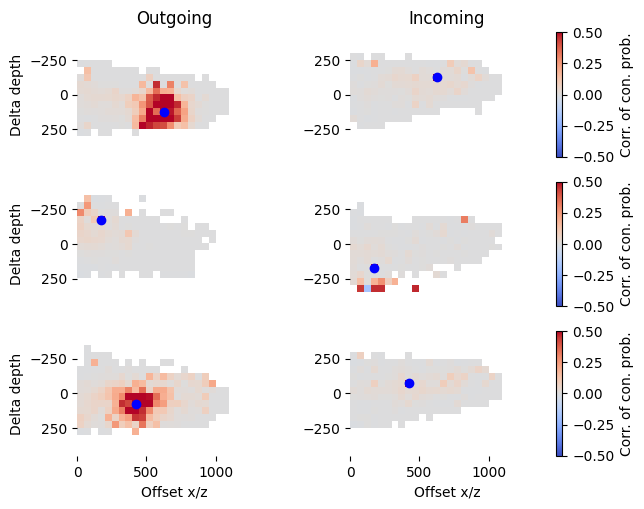

In [81]:
fig = plt.figure(figsize=(7, 5.5))
clim = [-0.5, 0.5]
location_ids = [223, 55, 150]
cmap="coolwarm"

pltid = 1
for _i, _loc in enumerate(location_ids): 
    ex_location = locations.iloc[_loc]
    ax = fig.add_subplot(3, 2, pltid)
    img = CC_pre[tuple(ex_location.values)].unstack("xz")
    pltimg = ax.imshow(img, extent=make_extent(img), clim=clim, cmap=cmap)
    plt.plot(ex_location["xz"], ex_location["y"], marker='o', color="blue")
    ax.set_ylabel("Delta depth")
    if pltid > 4:
        ax.set_xlabel("Offset x/z")
    if pltid < 3:
        ax.set_title("Outgoing")
    ax.set_frame_on(False)
    if _i < (len(location_ids) - 1):
        ax.set_xticks([])

    ax = fig.add_subplot(3, 2, pltid + 1)
    img = CC_post[tuple(ex_location.values)].unstack("xz")
    pltimg = ax.imshow(img, extent=make_extent(img), clim=clim, cmap=cmap)
    plt.plot(ex_location["xz"], ex_location["y"], marker='o', color="blue")
    plt.colorbar(pltimg, label="Corr. of con. prob.")
    if pltid > 4:
        ax.set_xlabel("Offset x/z")
    if pltid < 3:
        ax.set_title("Incoming")
    ax.set_frame_on(False)
    ax.set_ylim(sorted(ax.get_ylim()))
    if _i < (len(location_ids) - 1):
        ax.set_xticks([])
    pltid +=2

